In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
train_df = pd.read_csv('train.csv', index_col=0)
val_df = pd.read_csv('val.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


In [5]:
train_df

,temp,clouds_all,traffic_volume,day_sin,day_cos
0,0.760019,0.00,0.758755,0.853553,0.146447
1,0.738174,0.00,0.560765,0.750000,0.066987
2,0.698884,0.00,0.463513,0.629410,0.017037
3,0.668238,0.00,0.370029,0.500000,0.000000
4,0.643093,0.00,0.325101,0.370590,0.017037
...,...,...,...,...,...
12280,0.422599,0.90,0.599972,0.629410,0.982963
12281,0.421656,0.75,0.561881,0.750000,0.933013
12282,0.436272,0.90,0.567881,0.853553,0.853553
12283,0.439415,0.75,0.644482,0.933013,0.750000


Exploring how deeplearning models are trained for time series forecasting

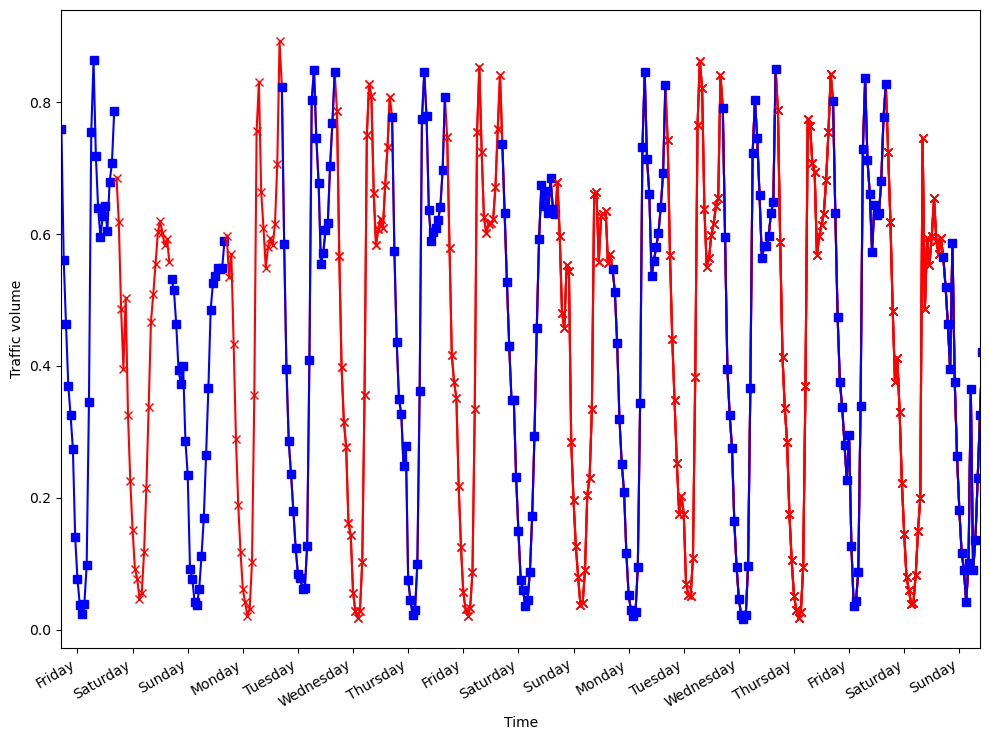

In [6]:
fig, ax = plt.subplots()

for n in range(0, 17, 2):
    start = 24*n
    stop = 24*(n+1)
    ax.plot(train_df.traffic_volume[start:stop], marker='s',
            color='blue', label='input')
    ax.plot(train_df.traffic_volume[stop:2*stop], marker='x', 
            color='red', label='label')
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 
                                   'Monday', 'Tuesday', 'Wednesday', 
                                   'Thursday', 'Friday', 'Saturday', 
                                   ' Sunday', 'Monday', 'Tuesday', 
                                   'Wednesday', 'Thursday', 'Friday', 
                                   'Saturday', 'Sunday'])
plt.xlim(0, 400)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [7]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        # 保存数据集
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # 如果指定了要预测的列，保存列索引信息
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        # 所有列的索引
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # 保存窗口参数
        self.input_width = input_width  # 输入的时间步数
        self.label_width = label_width  # 标签的时间步数
        self.shift = shift              # 输入与标签之间的偏移

        # 总窗口大小 = 输入步数 + 偏移（不是输入+输出）
        self.total_window_size = input_width + shift

        # 定义输入窗口的切片，例如 slice(0, 24) 表示前 24 个时间步是输入
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        # 定义输出标签的切片，例如 slice(24, None) 表示从第 24 个时间步往后是标签
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        # 切分输入和标签数据
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        
        # 如果有指定标签列，只保留那些列
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        
        # 显式设置输入输出的形状（None 表示任意）
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        # 可视化输入、标签、预测
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n + 1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='red', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        # 将原始数据转换为滑动时间窗口的 tf.data.Dataset
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        # 对每个窗口应用 split_to_inputs_labels
        ds = ds.map(self.split_to_inputs_labels)
        return ds

    # 生成训练集、验证集、测试集
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    # 随机采样一个 batch，用于可视化
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [8]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, 
                                label_columns=['traffic_volume']) 
wide_window = DataWindow(input_width=24, label_width=24, shift=1, 
                         label_columns=['traffic_volume'])

In [9]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [10]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

baseline_last = Baseline(label_index=column_indices['traffic_volume'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [11]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

110/110 [==============================] - 1s 5ms/step - loss: 0.0133 - mean_absolute_error: 0.0831


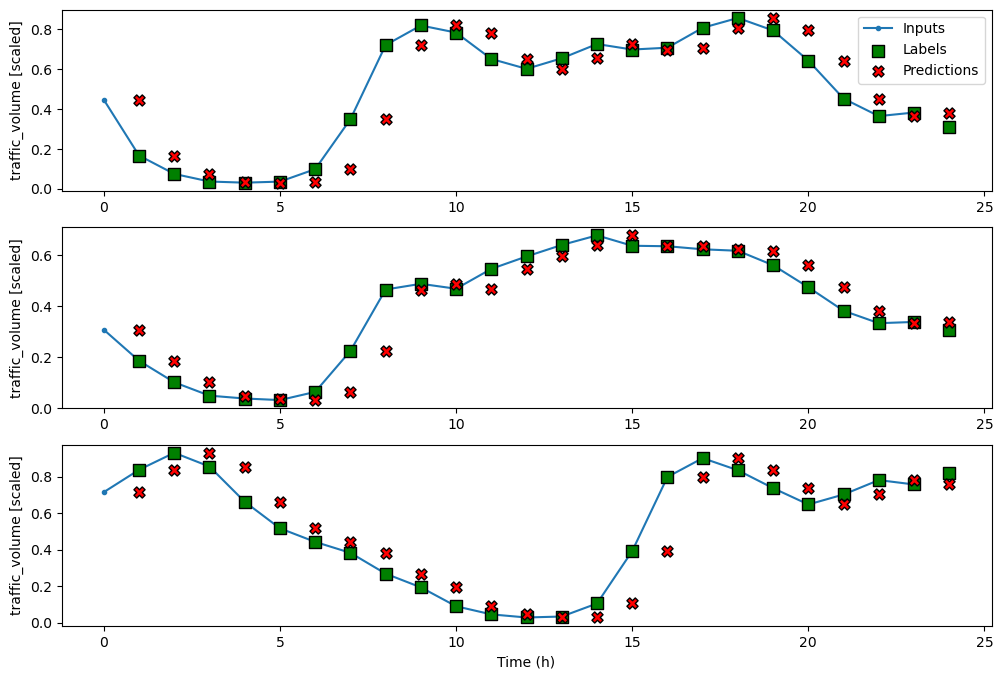

In [12]:
wide_window.plot(baseline_last)

In [13]:
print(performance['Baseline - Last'][1])

0.08128400146961212


Multi-step baseline models

In [14]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

In [15]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [16]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 0s 812us/step - loss: 0.1873 - mean_absolute_error: 0.3520


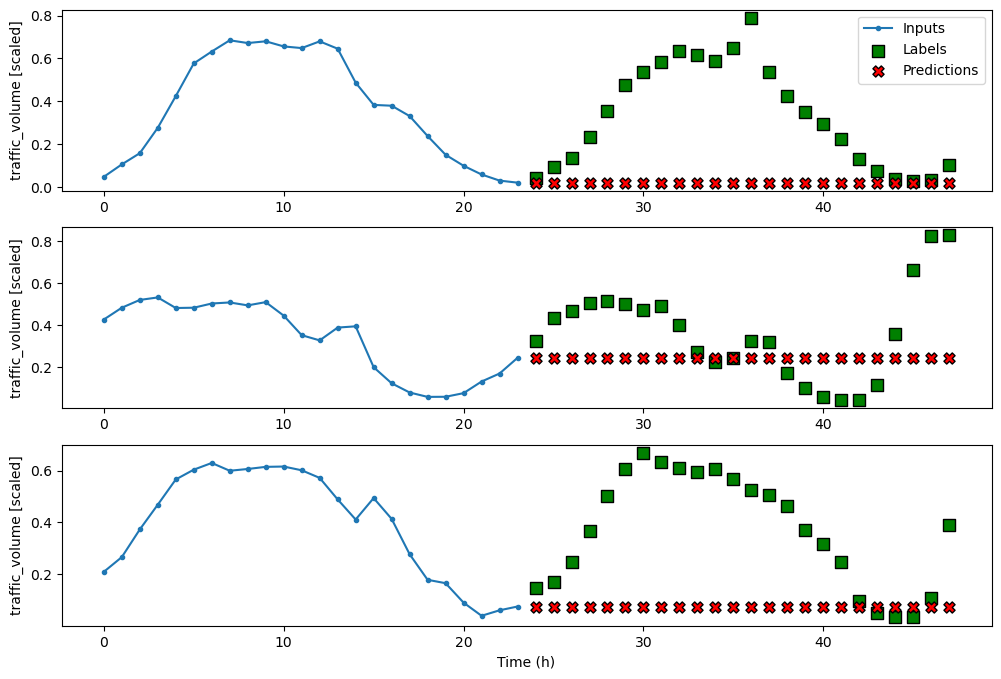

In [17]:
multi_window.plot(ms_baseline_last)

In [18]:
print(ms_performance['Baseline - Last'][1])

0.34698057174682617


In [19]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [20]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 0s 890us/step - loss: 0.0821 - mean_absolute_error: 0.2024


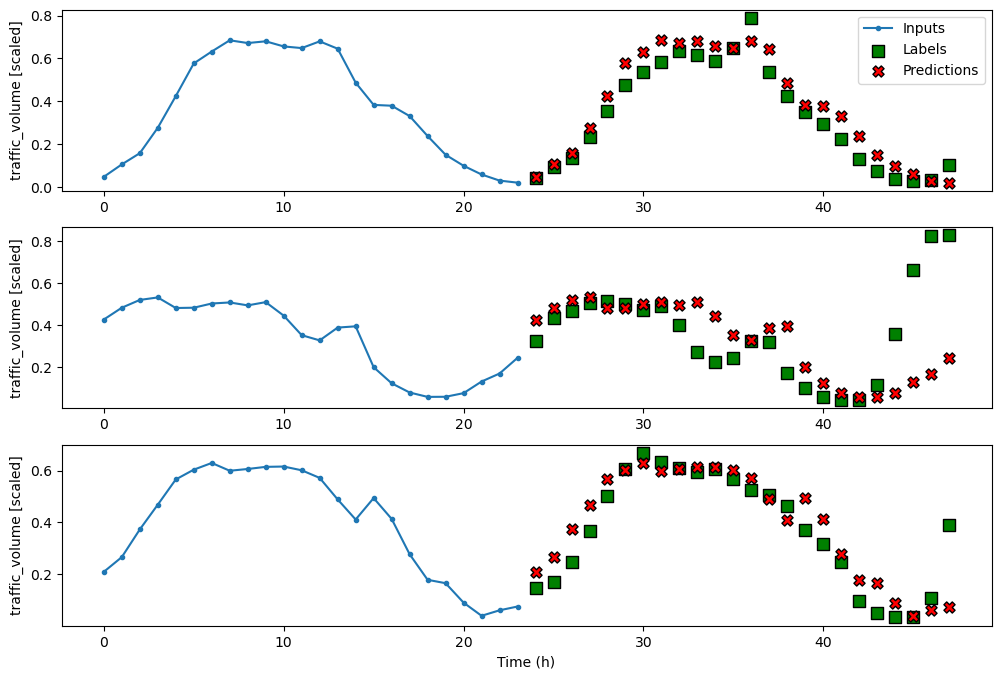

In [21]:
multi_window.plot(ms_baseline_repeat)

In [22]:
print(ms_performance['Baseline - Repeat'][1])

0.1955116242170334


Multi-output baseline model

In [23]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume']) 
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

In [24]:
print(column_indices['traffic_volume'])
print(column_indices['temp'])

2
0


In [25]:
mo_baseline_last = Baseline(label_index=[0, 2])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

109/109 [==============================] - 0s 1ms/step - loss: 0.0069 - mean_absolute_error: 0.0482


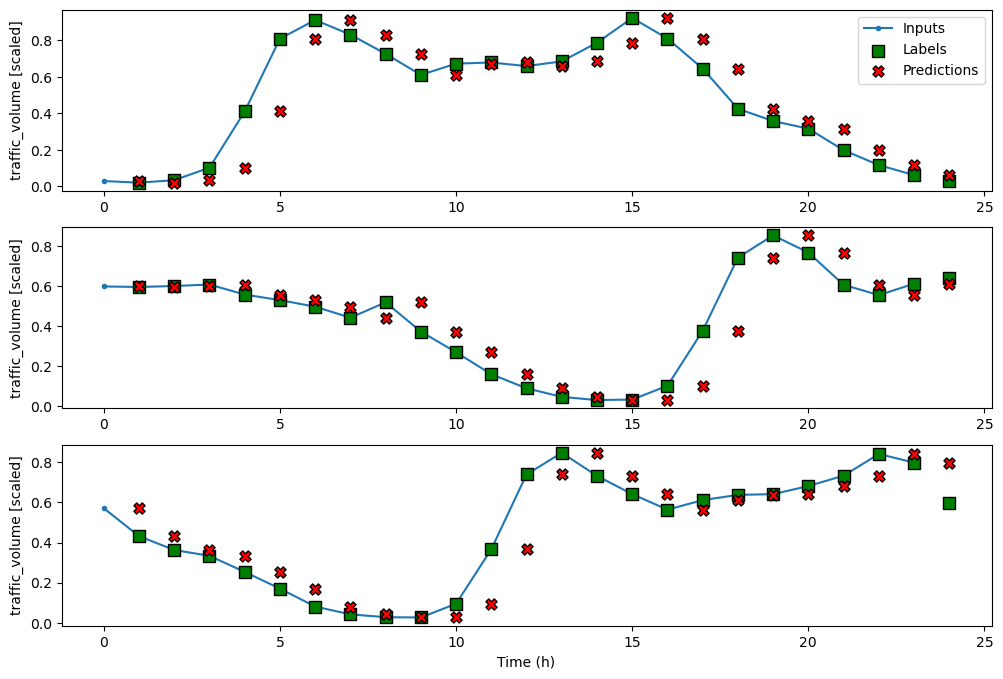

In [26]:
mo_wide_window.plot(mo_baseline_last)

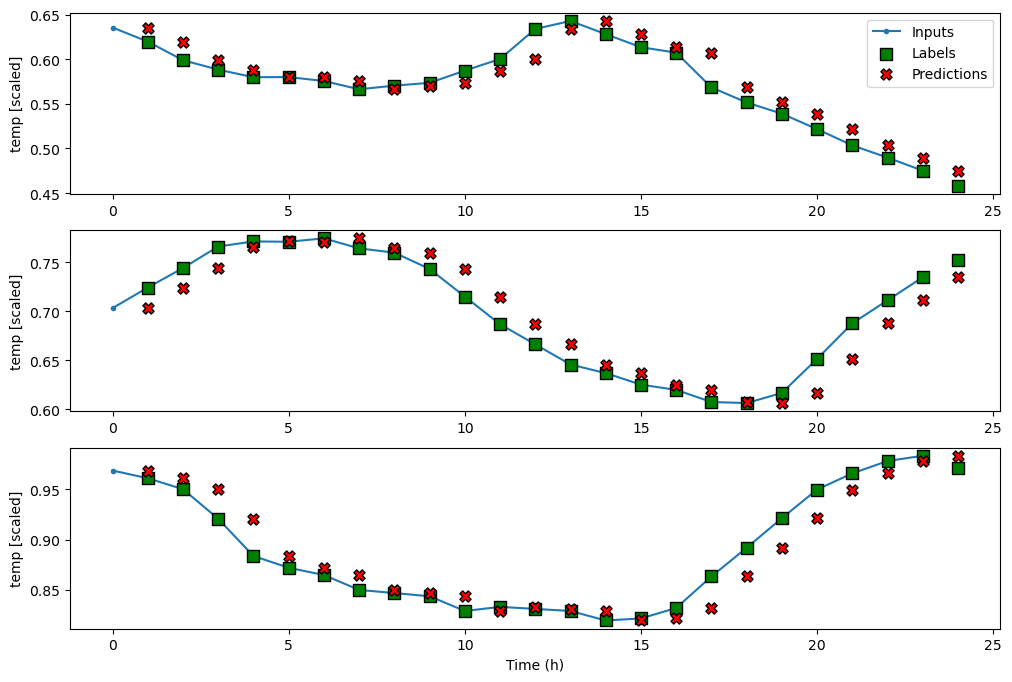

In [27]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')

In [28]:
print(mo_performance['Baseline - Last'][1])

0.04710666462779045


**Chapter 14**

Buliding a single-step linear model

In [29]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    model.compile(loss=MeanSquaredError(), optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    history = model.fit(window.train, epochs=max_epochs,
                        validation_data=window.val, callbacks=[early_stopping])
    return history

In [30]:
linear = Sequential([Dense(units=1)])
history = compile_and_fit(linear, single_step_window)
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 2s 3ms/step - loss: 0.1601 - mean_absolute_error: 0.3246 - val_loss: 0.1029 - val_mean_absolute_error: 0.2661
Epoch 2/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0754 - mean_absolute_error: 0.2261 - val_loss: 0.0628 - val_mean_absolute_error: 0.2032
Epoch 3/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0500 - mean_absolute_error: 0.1793 - val_loss: 0.0451 - val_mean_absolute_error: 0.1654
Epoch 4/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0384 - mean_absolute_error: 0.1531 - val_loss: 0.0358 - val_mean_absolute_error: 0.1427
Epoch 5/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0312 - mean_absolute_error: 0.1356 - val_loss: 0.0291 - val_mean_absolute_error: 0.1265
Epoch 6/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0254 - mean_absolute_error: 0.1210 - val_loss: 0.0236 - val_mean_absolute_error: 0.1128
Epoch 7/50
384/3

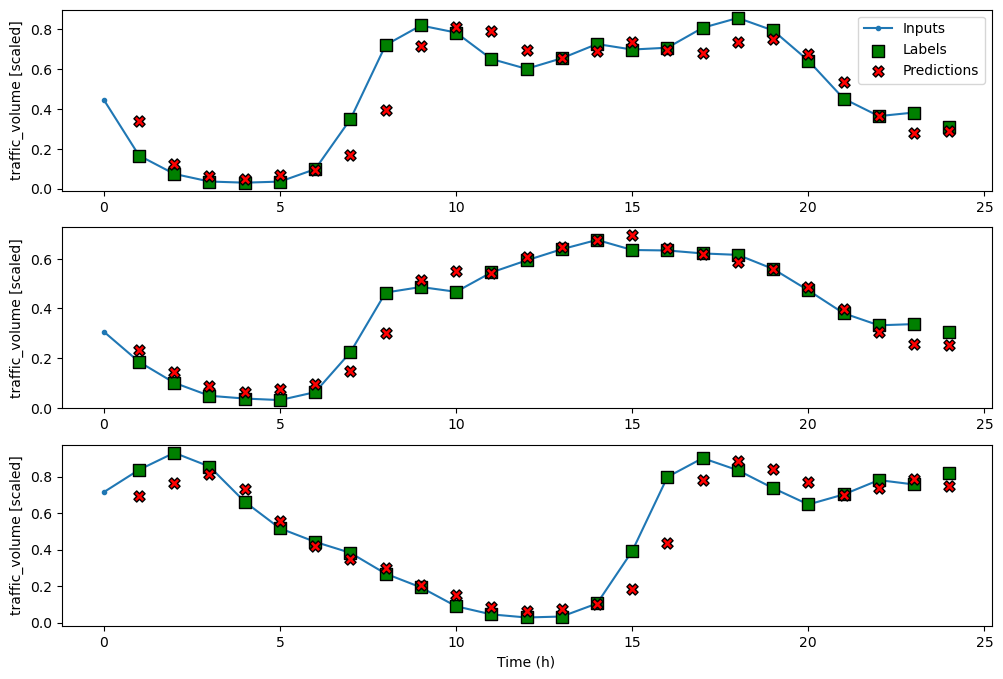

In [31]:
wide_window.plot(linear)

**Building a mutil-step linear model**

In [32]:
ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear, multi_window)

ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 2s 3ms/step - loss: 0.0703 - mean_absolute_error: 0.2078 - val_loss: 0.0346 - val_mean_absolute_error: 0.1515
Epoch 2/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0260 - mean_absolute_error: 0.1282 - val_loss: 0.0240 - val_mean_absolute_error: 0.1218
Epoch 3/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0194 - mean_absolute_error: 0.1064 - val_loss: 0.0200 - val_mean_absolute_error: 0.1059
Epoch 4/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0173 - mean_absolute_error: 0.0967 - val_loss: 0.0189 - val_mean_absolute_error: 0.0987
Epoch 5/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0167 - mean_absolute_error: 0.0925 - val_loss: 0.0185 - val_mean_absolute_error: 0.0952
Epoch 6/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0165 - mean_absolute_error: 0.0901 - val_loss: 0.0183 - val_mean_absolute_error: 0.0934
Epoch 7/50
383/3

In [33]:
mo_linear = Sequential([
    Dense(units=2)
])

history = compile_and_fit(mo_linear, mo_single_step_window)

mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 1s 3ms/step - loss: 0.1914 - mean_absolute_error: 0.3641 - val_loss: 0.1215 - val_mean_absolute_error: 0.2983
Epoch 2/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0800 - mean_absolute_error: 0.2399 - val_loss: 0.0530 - val_mean_absolute_error: 0.1938
Epoch 3/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0334 - mean_absolute_error: 0.1527 - val_loss: 0.0212 - val_mean_absolute_error: 0.1197
Epoch 4/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0139 - mean_absolute_error: 0.0948 - val_loss: 0.0094 - val_mean_absolute_error: 0.0757
Epoch 5/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0620 - val_loss: 0.0058 - val_mean_absolute_error: 0.0525
Epoch 6/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0054 - mean_absolute_error: 0.0463 - val_loss: 0.0049 - val_mean_absolute_error: 0.0429
Epoch 7/50
384/3

In [34]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 2s 2ms/step - loss: 0.0090 - mean_absolute_error: 0.0666 - val_loss: 0.0041 - val_mean_absolute_error: 0.0476
Epoch 2/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0038 - mean_absolute_error: 0.0451 - val_loss: 0.0029 - val_mean_absolute_error: 0.0407
Epoch 3/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0032 - mean_absolute_error: 0.0415 - val_loss: 0.0024 - val_mean_absolute_error: 0.0364
Epoch 4/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0029 - mean_absolute_error: 0.0385 - val_loss: 0.0027 - val_mean_absolute_error: 0.0396
Epoch 5/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0026 - mean_absolute_error: 0.0368 - val_loss: 0.0020 - val_mean_absolute_error: 0.0325
Epoch 6/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0025 - mean_absolute_error: 0.0354 - val_loss: 0.0018 - val_mean_absolute_error: 0.0309
Epoch 7/50
384/3

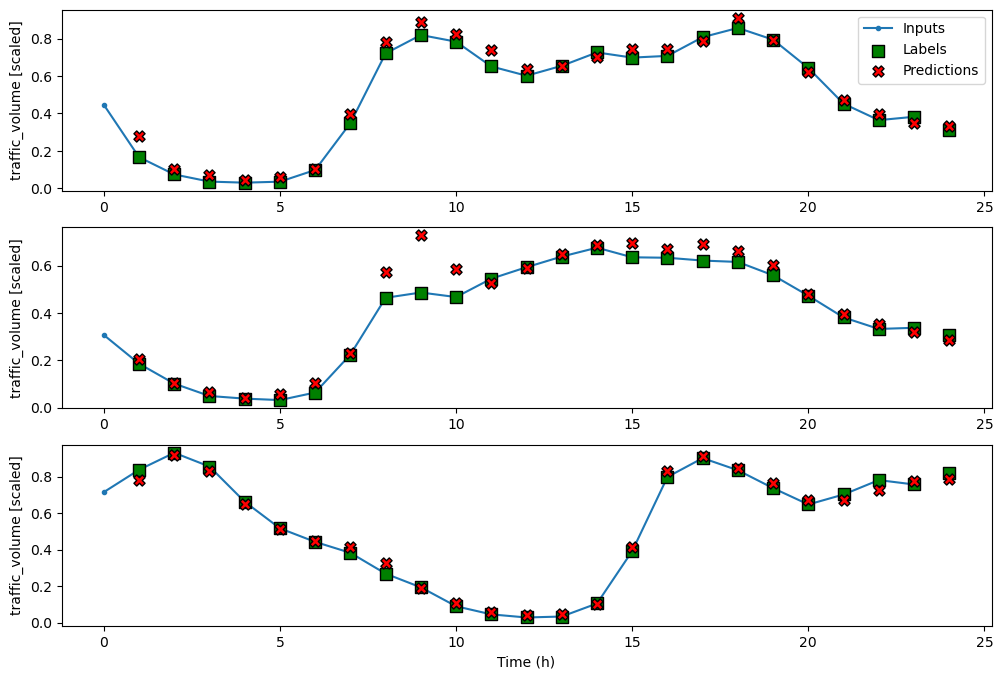

In [35]:
wide_window.plot(dense)

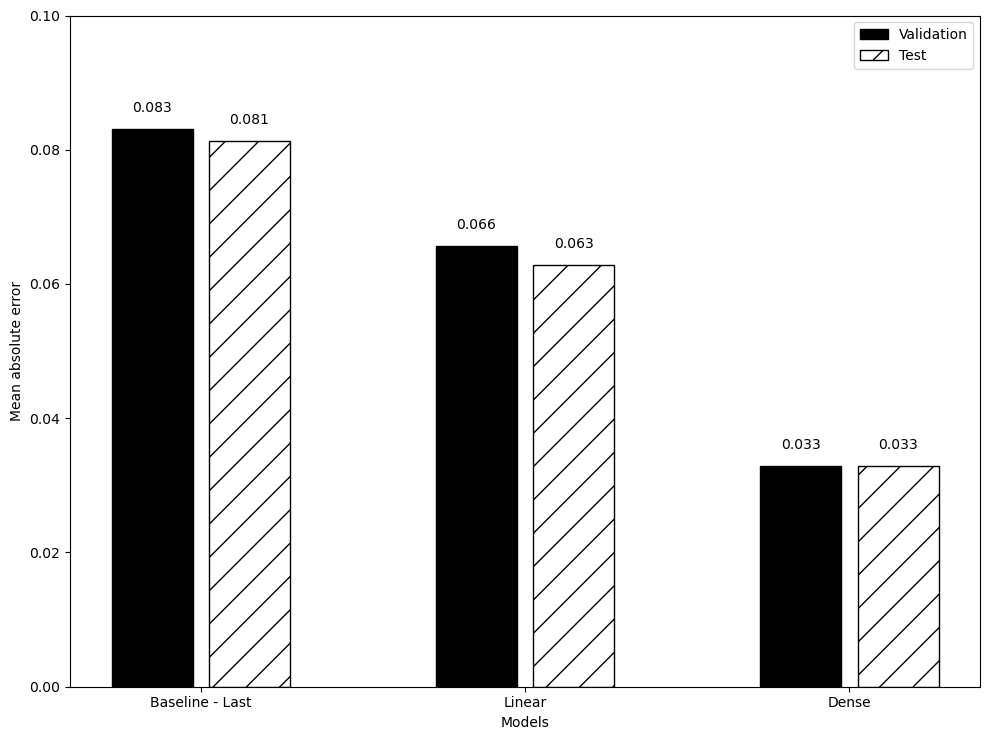

In [36]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

In [37]:
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_dense, multi_window)

ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 2s 4ms/step - loss: 0.0286 - mean_absolute_error: 0.1104 - val_loss: 0.0160 - val_mean_absolute_error: 0.0813
Epoch 2/50
383/383 [==============================] - 1s 3ms/step - loss: 0.0139 - mean_absolute_error: 0.0779 - val_loss: 0.0158 - val_mean_absolute_error: 0.0793
Epoch 3/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0134 - mean_absolute_error: 0.0768 - val_loss: 0.0152 - val_mean_absolute_error: 0.0848
Epoch 4/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0133 - mean_absolute_error: 0.0770 - val_loss: 0.0148 - val_mean_absolute_error: 0.0829
Epoch 5/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0131 - mean_absolute_error: 0.0763 - val_loss: 0.0147 - val_mean_absolute_error: 0.0769
Epoch 6/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0129 - mean_absolute_error: 0.0760 - val_loss: 0.0144 - val_mean_absolute_error: 0.0774
Epoch 7/50
383/3

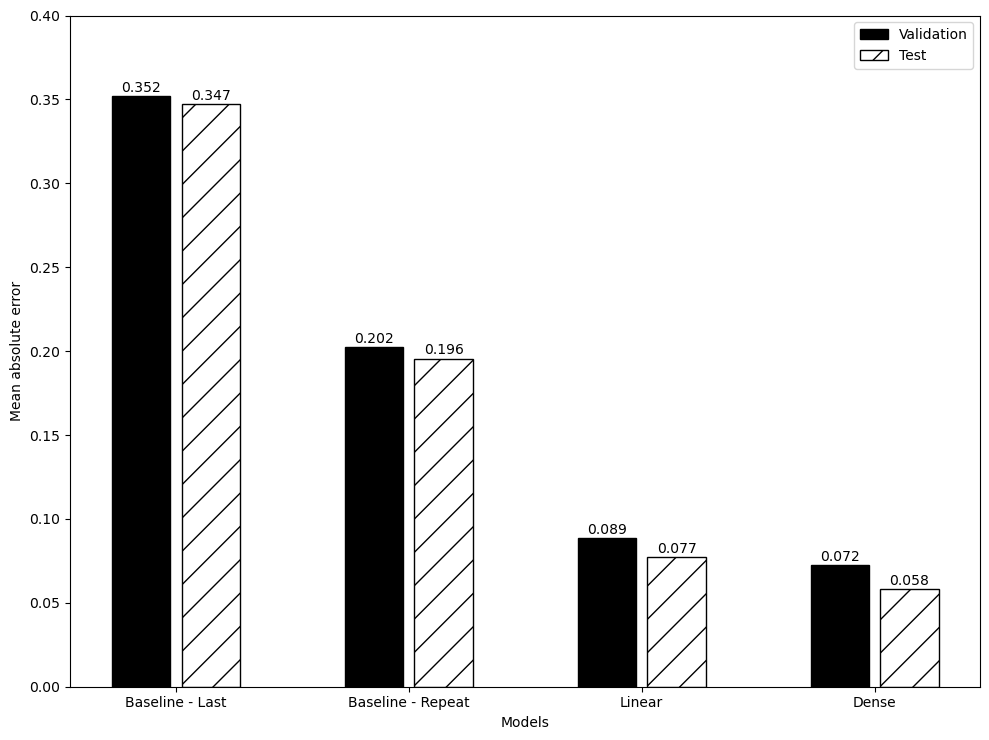

In [38]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

In [39]:
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_dense, mo_single_step_window)

mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 2s 2ms/step - loss: 0.0135 - mean_absolute_error: 0.0656 - val_loss: 0.0026 - val_mean_absolute_error: 0.0330
Epoch 2/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0025 - mean_absolute_error: 0.0312 - val_loss: 0.0021 - val_mean_absolute_error: 0.0291
Epoch 3/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0022 - mean_absolute_error: 0.0290 - val_loss: 0.0016 - val_mean_absolute_error: 0.0260
Epoch 4/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0020 - mean_absolute_error: 0.0276 - val_loss: 0.0016 - val_mean_absolute_error: 0.0266
Epoch 5/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0265 - val_loss: 0.0013 - val_mean_absolute_error: 0.0232
Epoch 6/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0017 - mean_absolute_error: 0.0253 - val_loss: 0.0012 - val_mean_absolute_error: 0.0225
Epoch 7/50
384/3

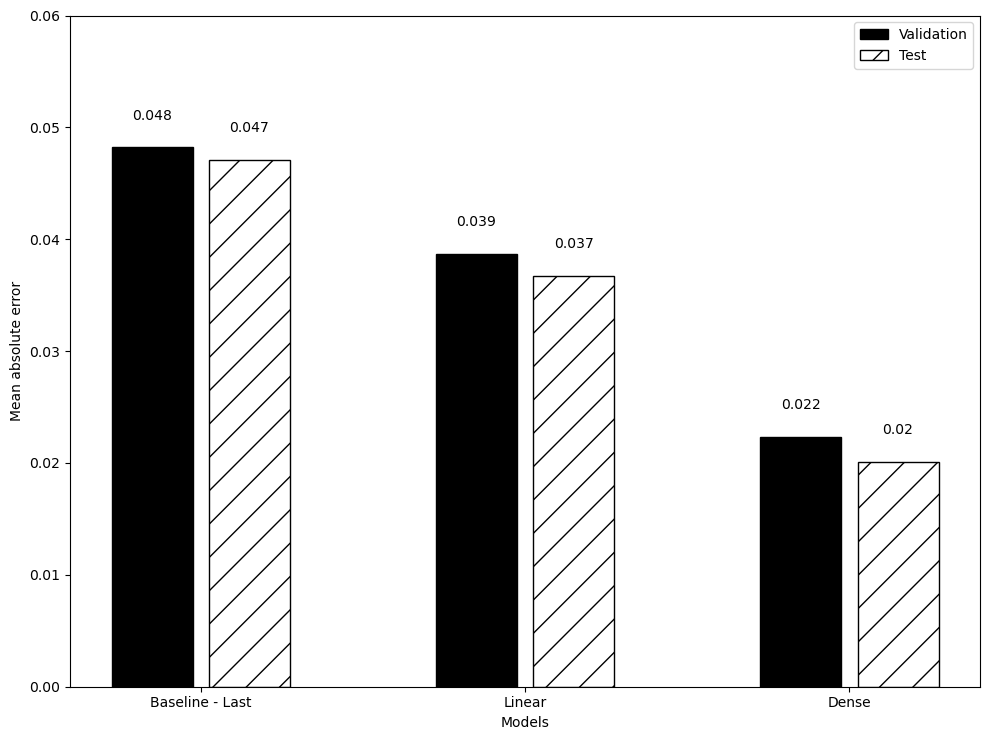

In [40]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()